In [194]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk
from scipy import stats

from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime, date, timedelta

import gensim
import os

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize
from operator import itemgetter
import seaborn as sns
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel
from collections import Counter

import numpy as np
import pandas as pd

import operator

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [195]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [196]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk

from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

import calendar

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [197]:
np.random.seed(42)

In [198]:
os.chdir(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/"
)

# Part 1

## Data Preparation

In [199]:
df_customer_Churn = pd.read_csv("Data/Daily_Churned_customers_JET.csv")

df_input_accounts = pd.read_csv("Data/input_accounts_21_10_2022.csv")

df_tweets = pd.read_csv("Data/tweets-2022-10-21_justeattakeaway.csv")

In [200]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

In [201]:
# add a simple dummy for JET companies or not
df_tweets["JET"] = 0
df_tweets.loc[
    df_tweets.full_name.isin(
        ["Thuisbezorgd.nl", "thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"]
    ),
    "JET",
] = 1

# remove all non english tweets
df_mergeddf_tweets = df_tweets[df_tweets.lang == "en"]

df_tweets.reset_index(inplace=True, drop=True)

In [202]:
# delta chrun
df_customer_Churn["d_churn"] = df_customer_Churn[
    "Churned customers"
] - df_customer_Churn["Churned customers"].shift(1)

In [203]:
df_tweets["reply_count"] = df_tweets["reply_count"] + 0.0001
df_tweets["like_count"] = df_tweets["like_count"] + 0.0001
df_tweets["retweet_count"] = df_tweets["retweet_count"] + 0.0001

In [204]:
# time question
df_tweets["created_at"] = pd.to_datetime(df_tweets.created_at)
df_tweets["year"] = pd.DatetimeIndex(df_tweets.created_at).year
df_tweets["month"] = pd.DatetimeIndex(df_tweets.created_at).month
df_tweets["day"] = pd.DatetimeIndex(df_tweets.created_at).day
df_tweets["hour"] = pd.DatetimeIndex(df_tweets.created_at).hour


df_tweets["Month_t"] = df_tweets["month"].apply(lambda x: calendar.month_abbr[x])
# weekday
df_tweets["weekday"] = df_tweets.created_at.dt.strftime("%A")

# summer/Winter/ quarters
df_tweets["season_quarters"] = pd.DatetimeIndex(df_tweets.created_at).quarter

# a simple trick to create "seasons"
df_tweets["season"] = df_tweets.month % 12 // 3 + 1

# Part 2

## Lanugage Preprocessing and some modeling

In [205]:
additional = [
    "rt",
    "rts",
    "retweet",
    "please",
    "ha",
    "w",
    "dm",
    "amp",
]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["simple_preprocessing"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

In [206]:
# hashtags_df = df_tweets["text"].apply(
#     lambda x: pd.value_counts(re.findall("(#\w+)", x.lower()))
# )


# for i, r in hashtags_df.iterrows():
#     if len(r[r == 1].index) > 0:
#         df_tweets.loc[i, "simple_preprocessing"] = (
#             df_tweets.iloc[i].simple_preprocessing
#             + " "
#             + " ".join(list(r[r == 1].index))
#         )

## Only use JET

In [207]:
# only use JET tweets
df_tweets_jet = df_tweets[df_tweets.JET == 1]

## Only NOT in reply to user but only offerings by the customers 

In [208]:
df_tweets_jet = df_tweets_jet[df_tweets_jet.in_reply_to_user_id.isna()]

## Lemmatize

In [209]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]

In [210]:
swords = set().union(stopwords.words("english"), additional)

count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 2),  # will create a vocabulary with 1-gram and 2-grams
    min_df=2,
    max_df=0.9,
    max_features=2000,
    lowercase=True,
    strip_accents="unicode",
)

In [211]:
matrix = count.fit_transform(df_tweets_jet.simple_preprocessing)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())

## Question 2 

# describe JET's 


## 2.1: for this question only focus on what the company did and only their tweets and NOT IN REPLY!


2.1 What are the main topics the company tweets about? What are the most used words / hashtags / bigrams (trigrams)? How often and in which moments of time does the platform post tweets most often?* (1 slide)

*Before you analyze the texts of tweets, please, preprocess the texts of tweets. You can find the list of simple preprocessing steps below, but you may also do any more sophisticated preprocessing (upon your choice).


for 2.1: 
- Only what did the company tweet about
- what topics did they tweet about?


In [212]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())


K = 12
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

#### 2. 1 what topics did they tweet about?

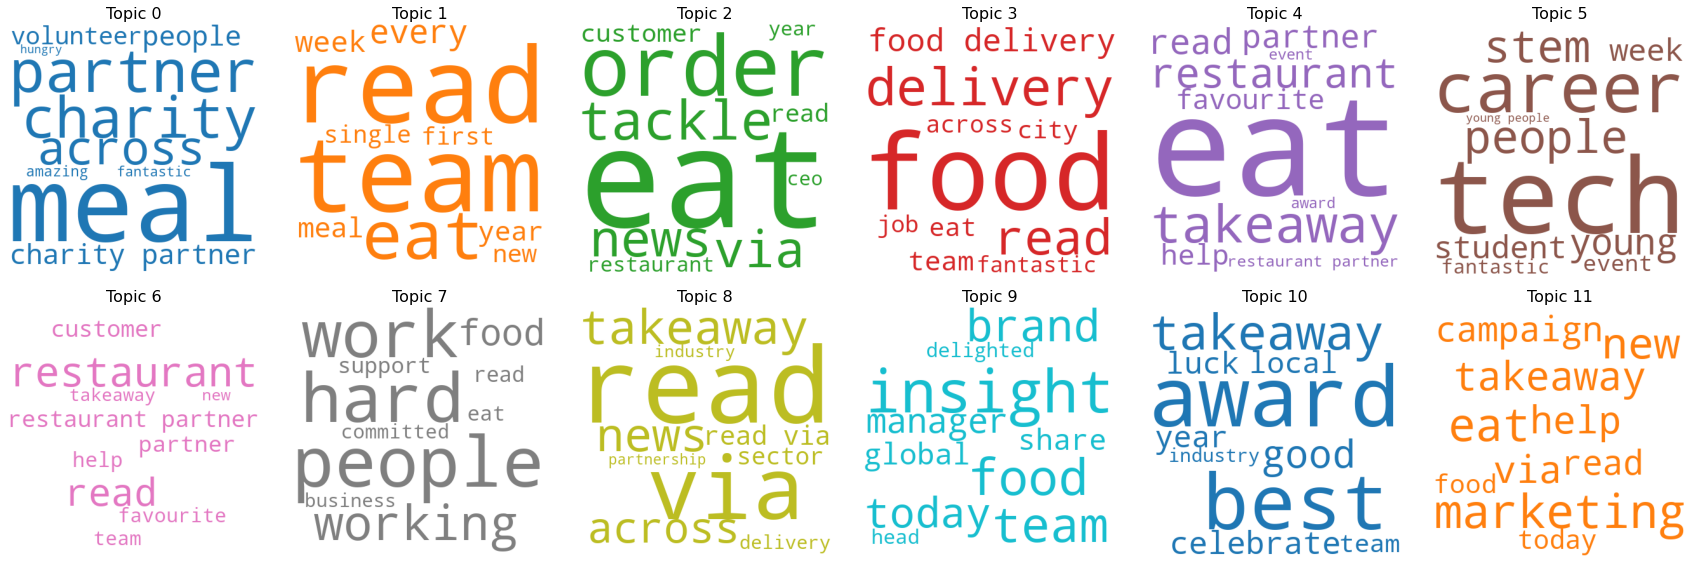

In [213]:
nb_columns = 6
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=20,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [214]:
names = [
    "CRM & Partner Management",
    "External Celebration",
    "Novelties & Business Innovations",
    "Human Captial Generation",
    "Charity",
    "Plastic & SCG",
]

topic_names = {i: v for i, v in enumerate(names)}

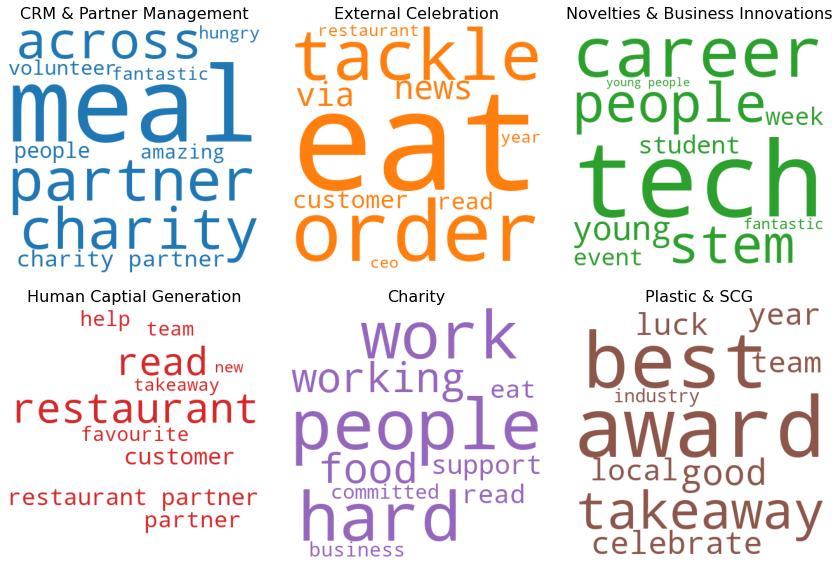

In [215]:
####################################
K = 12
topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


topics = operator.itemgetter(0, 2, 5, 6, 7, 10)(topics)

nb_columns = 3
K = len(topics)
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title(str(names[i]), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [216]:
# this will help to reassign topics
by_get_document_topics = list(map(lda.get_document_topics, corpus))

# extract topic loadings and topics by document
topic_loadings = []
topic_number = []
for loading in by_get_document_topics:
    t = list(map(itemgetter(1), loading))
    topic_loadings.append(max(t))
    topic_number.append(t.index(max(t)))

In [217]:
df_tweets_jet["topic_number"] = topic_number
df_tweets_jet["topic_loadings"] = topic_loadings

In [218]:
# essentially, if the tweet does not load on a relevant topic such as 0 or 10, it is going to get an unimporatance sticker
df_tweets_jet["relevant_topic_loading"] = 1
df_tweets_jet.loc[
    ~df_tweets_jet.topic_number.isin([0, 2, 5, 6, 7, 10]), "relevant_topic_loading"
] = 0

#### 2. 1 Hashtags, bigrams


In [219]:
# most fequent words and trigrams
# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_jet["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)


additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())
    counter += 1

df_results["length"] = additiona.values()

In [220]:
# obtain the bigrams using the basic preprocessing

bigramsearies = pd.Series(
    [
        word
        for sublist in df_tweets_jet.processed_text.dropna()
        .apply(lambda x: [i for i in bigrams(x)])
        .tolist()
        for word in sublist
    ]
).value_counts()

In [221]:
# extract the hashtags
hashtags_df = df_tweets_jet[df_tweets_jet.text.str.contains("#")].text.str.findall(
    r"#.*?(?=\s|$)"
)

# 1. stack the hashtags and count them
hashtags_count = dict(Counter(x for xs in list(hashtags_df.values) for x in set(xs)))

hashtags_count = {
    k: v
    for k, v in sorted(hashtags_count.items(), reverse=True, key=lambda item: item[1])
}

hashtags_df = pd.DataFrame(hashtags_df).rename(columns={"text": "hashtag"})

df_tweets_jet = pd.merge(
    left=df_tweets_jet, right=hashtags_df, left_index=True, right_index=True, how="left"
)


hashtags_df = (
    df_tweets_jet["text"]
    .apply(lambda x: pd.value_counts(re.findall("(#\w+)", x.lower())))
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .sort_values(by=0, ascending=False)
)
hashtags_df.columns = ["hashtag", "occurences"]

"""

What is notable from the stacked hashtags is that the location tag is obviously frequently used to show the targeted location of the tweet.

However, based on the reasonably large frequency of '#stem': 43,  '#tech': 34, '#womenintech': 25, '#tech.': 12,
 '#foodtech': 12,
 '#plasticfree': 12, '#innovation': 12,  '#tech!': 24,
 --> we can see that 1. JET uses the tweets to find new employees, to futher women in tech and also to promote themselfes as 
 a tech platfrom attracting human capital

--> This also goes hand in hand with the findings from the topic modeling in which tech is a prominent feature in all feaeatures 
"""

"\n\nWhat is notable from the stacked hashtags is that the location tag is obviously frequently used to show the targeted location of the tweet.\n\nHowever, based on the reasonably large frequency of '#stem': 43,  '#tech': 34, '#womenintech': 25, '#tech.': 12,\n '#foodtech': 12,\n '#plasticfree': 12, '#innovation': 12,  '#tech!': 24,\n --> we can see that 1. JET uses the tweets to find new employees, to futher women in tech and also to promote themselfes as \n a tech platfrom attracting human capital\n\n--> This also goes hand in hand with the findings from the topic modeling in which tech is a prominent feature in all feaeatures \n"

In [222]:
# hashtags and bigrams plot
df_bigramsearies = pd.DataFrame.from_dict(
    dict(bigramsearies), orient="index", columns=["Counts_Bigram"]
).reset_index()

In [223]:
df_bigramsearies.rename(columns={"index": "bigrams"}, inplace=True)

df_bigramsearies["bigrams"] = df_bigramsearies["bigrams"].astype(str)

In [224]:
hashtags_df = hashtags_df.reset_index().drop(columns=["index"])
hashtags_df_features = hashtags_df.copy()

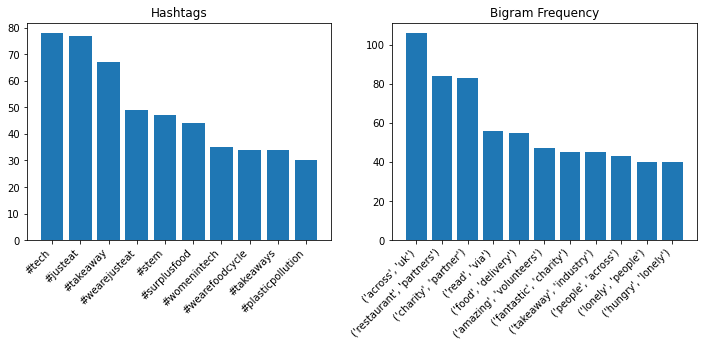

In [225]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(data=hashtags_df.iloc[2:12, :], height="occurences", x="hashtag")
ax1.set_xticklabels(
    labels=hashtags_df.iloc[2:12, :]["hashtag"], rotation=45, ha="right"
)
ax1.set_title("Hashtags")

ax2.bar(data=df_bigramsearies.loc[:10, :], height="Counts_Bigram", x="bigrams")

ax2.set_xticklabels(
    labels=df_bigramsearies.loc[:10, :]["bigrams"], rotation=45, ha="right"
)
ax2.set_title("Bigram Frequency")

plt.show()

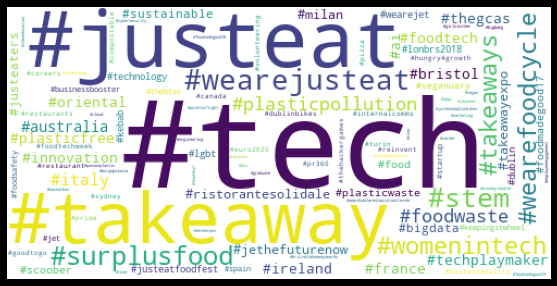

In [226]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(
    dict(hashtags_df.iloc[2:, :].set_index("hashtag").occurences)
)

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(10, 5), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [227]:
# df_tweets_jet[df_tweets_jet.processed_words_lemma.str.join("").str.contains("tech")]

#### 2. 1 General Wordclouds

In [228]:
# Join the different processed titles together.
long_string = []
for i in df_tweets_jet.processed_words_lemma:
    long_string.extend(i)


long_string = " ".join(long_string)

In [229]:
# this is not frequency based so better not use it

# # Create a WordCloud object
# wordcloud = WordCloud(
#     width=1600,
#     height=800,
#     background_color="white",
#     max_words=200,
#     contour_width=3,
#     contour_color="steelblue",
# )


# # Generate a word cloud
# wordcloud.generate(str(long_string))

# # Visualize the word cloud
# wordcloud.to_image()


# plt.figure(figsize=(20, 10), facecolor="k")
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

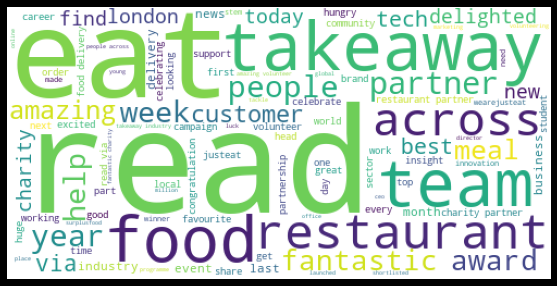

In [230]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(dict(df_results.count_words))

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(10, 5), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

#### 2. 1 How often does the company tweet per month (beginning or end of month), weekdays

consider wrt when in a month the company tweets the costs of advertising; they might tweeet more during times when there is less to gain from conventional stuff happening







Important: i do assume that the Time Zone issues of London vs other times is fixed and reflected in the original timezone!




"thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"

In [231]:
# group by function
def groupby_time(df_, time_col):
    cats = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    df_return = df_.groupby(by=time_col).agg({"tweet_id": "count"}).reset_index()
    return df_return.groupby([time_col]).sum().reindex(cats)

In [232]:
df_plot = groupby_time(df_tweets_jet, "weekday").reset_index()

In [233]:
df_tmp_ = pd.DataFrame(np.arange(1, 25), columns=["hour"])

df_tmp_2 = df_tweets_jet.groupby(by="hour").agg({"tweet_id": "count"}).reset_index()

df_ploth = pd.merge(
    left=df_tmp_, right=df_tmp_2, left_on="hour", right_on="hour", how="left"
).fillna(0)


df_tmp_2, df_tmp_ = None, None

In [234]:
df_tweets_jet_month_weekday = (
    df_tweets_jet.groupby(by=["Month_t", "weekday"])
    .agg({"tweet_id": "count"})
    .reset_index()
)

In [235]:
df_tweets_jet_month_weekday
# convert to month_weekday one column

df_tweets_jet_month_weekday["month_weekday"] = (
    df_tweets_jet_month_weekday.Month_t.astype(str)
    + "-"
    + df_tweets_jet_month_weekday.weekday.astype(str)
)

In [236]:
# trace1 = go.Bar(
#     x=df_plot.weekday,
#     y=df_plot.tweet_id,
#     name="No. of stations",
#     # text=temp_df1.id,
#     textposition="outside",
#     # marker=dict(color=chosen_colors[0]),
# )


# data = [trace1]

# layout = go.Layout(
#     title="Frequency of Tweets",
#     xaxis=dict(title="WeekDay"),
#     yaxis=dict(title="Twee"),
# )

# figure = go.Figure(data=data, layout=layout)

# iplot(figure)

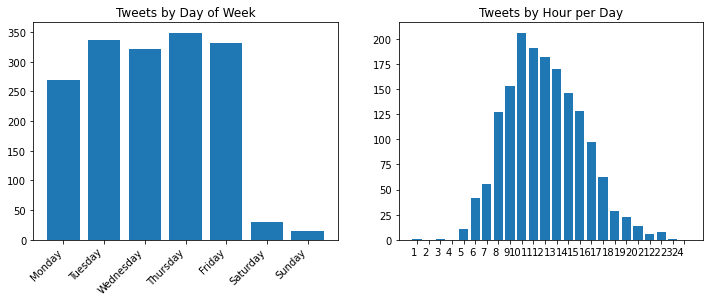

In [237]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(height=df_plot.tweet_id, x=df_plot.weekday)
ax1.set_xticklabels(labels=df_plot.weekday, rotation=45, ha="right")
ax1.set_title("Tweets by Day of Week")

ax2.bar(height=df_ploth.tweet_id, x=df_ploth.hour)
ax2.set_xticks(np.arange(1, 25))
ax2.set_xticklabels(labels=np.arange(1, 25), rotation=0, ha="right")
ax2.set_title("Tweets by Hour per Day")

plt.show()

In [238]:
"""
what is interresting about this plot is that there is almost no planning nad automatiion for the weekend in terms 
of tweets while this seems to be lost potentipoal in free advertising during which people have time to scroll through social media

the problem: there was less indiction regarding the core buisiness and mostly tweets about general things!

"""

'\nwhat is interresting about this plot is that there is almost no planning nad automatiion for the weekend in terms \nof tweets while this seems to be lost potentipoal in free advertising during which people have time to scroll through social media\n\nthe problem: there was less indiction regarding the core buisiness and mostly tweets about general things!\n\n'

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)​


### Repeated Preprocessing based on all tweets with replies and not being replies

### and merge the two datasets then later again 

In [239]:
df_tweets_tot = df_tweets[
    (df_tweets.JET == 1) & ~(df_tweets.in_reply_to_user_id.isna())
]

In [240]:
matrix = count.fit_transform(df_tweets_tot.simple_preprocessing)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())

corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())


K = 12
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

In [241]:
# this will help to reassign topics
by_get_document_topics = list(map(lda.get_document_topics, corpus))

# extract topic loadings and topics by document
topic_loadings = []
topic_number = []
for loading in by_get_document_topics:
    t = list(map(itemgetter(1), loading))
    topic_loadings.append(max(t))
    topic_number.append(t.index(max(t)))

df_tweets_tot["topic_number"] = topic_number
df_tweets_tot["topic_loadings"] = topic_loadings


# now just add a 12 to it so that it corresponds
df_tweets_tot["topic_number"] += 12

In [242]:
# most fequent words and trigrams
# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_tot["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)

In [243]:
additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())
    counter += 1

df_results["length"] = additiona.values()


bigramsearies = pd.Series(
    [
        word
        for sublist in df_tweets_tot.processed_text.dropna()
        .apply(lambda x: [i for i in bigrams(x)])
        .tolist()
        for word in sublist
    ]
).value_counts()

In [244]:
# extract the hashtags
hashtags_df = df_tweets_tot[df_tweets_tot.text.str.contains("#")].text.str.findall(
    r"#.*?(?=\s|$)"
)

# 1. stack the hashtags and count them
hashtags_count = dict(Counter(x for xs in list(hashtags_df.values) for x in set(xs)))

hashtags_count = {
    k: v
    for k, v in sorted(hashtags_count.items(), reverse=True, key=lambda item: item[1])
}

hashtags_df = pd.DataFrame(hashtags_df).rename(columns={"text": "hashtag"})

df_tweets_tot = pd.merge(
    left=df_tweets_tot, right=hashtags_df, left_index=True, right_index=True, how="left"
)

In [245]:
df_tweets_tot["relevant_topic_loading"] = 0

# merge 

In [246]:
len(df_tweets_tot) + len(df_tweets_jet)

8874

In [247]:
df_merged = df_tweets_tot.append(df_tweets_jet, ignore_index=True)

## Sentiment analyis

In [248]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_merged["sentiment_score"] = df_merged["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_merged[["processed_words_lemma", "sentiment_score"]].head(n=10)

# df_tweets_jet["sentiment_score"].apply(
#     lambda x: round(
#         x,
#     )
# ).value_counts()

df_merged["round_sentiment"] = df_merged["sentiment_score"].apply(
    lambda x: round(
        x,
    )
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [249]:
# create sentiment score for regression eg a dummy
df_merged["rank_round_sentiment"] = df_merged["round_sentiment"].rank(method="first")

df_merged["quantile_round_sentiment"] = df_merged["rank_round_sentiment"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

In [250]:
df_merged["sentiment_class"] = "nan"
df_merged.loc[df_merged.sentiment_score < 0, "sentiment_class"] = "negative"
df_merged.loc[
    (df_merged.sentiment_score >= 0) & (df_merged.sentiment_score < 7),
    "sentiment_class",
] = "neutral"
df_merged.loc[(df_merged.sentiment_score >= 7), "sentiment_class"] = "positive"

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)​


#### First insight: overall positive compound loading which makes sense considering the promotional channel

#### however, the loadings of sentiment is considerably higher/stronger on non_reply_to_users than tweets in reply to users



Main insight: Twitter is first and foremost a communcation tool; you publish novelties, and then you do damage control with your enraged customers in quick commerce.

Those in reply to user are considerably HIEGHER (T TEST!!!!! POTENTIAL HERE)

In [251]:
## show the basic range of values for the
df_merged.round_sentiment.value_counts()

 0     4207
 1     1733
 2     1111
 3      703
 4      581
 5      196
-1      191
 6      113
 9        9
 8        8
 7        7
 10       5
-2        4
 11       3
 12       2
 13       1
Name: round_sentiment, dtype: int64

In [252]:
# Not in reply to users
df_merged[df_merged.in_reply_to_user_id.isna()].sentiment_score.mean()

1.6123454655380887

In [253]:
# in reply to users
df_merged[~df_merged.in_reply_to_user_id.isna()].sentiment_score.mean()

1.062376094182829

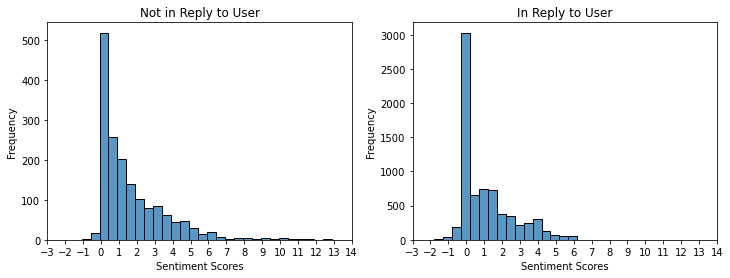

In [254]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    data=df_merged[df_merged.in_reply_to_user_id.isna()],
    x="sentiment_score",
    binwidth=0.5,
    ax=ax1,
)
ax1.set_xlabel("Sentiment Scores")
ax1.set_ylabel("Frequency")
ax1.set_title("Not in Reply to User")
ax1.set_xticks(np.arange(-3, 15, 1))

sns.histplot(
    data=df_merged[~df_merged.in_reply_to_user_id.isna()],
    x="sentiment_score",
    binwidth=0.5,
    ax=ax2,
)
ax2.set_xlabel("Sentiment Scores")
ax2.set_ylabel("Frequency")
ax2.set_title("In Reply to User")
ax2.set_xticks(np.arange(-3, 15, 1))

plt.show()

#### Second Insight: Certain topics load high on sentiment when compared to other topics; particularly those 
External Celebration	1.476357
CRM & Partner Management	1.712045

In [255]:
tmp_dict = {
    0: "CRM & Partner Management",
    2: "External Celebration",
    5: "Novelties & Business Insights",
    6: "Human Captial Generation",
    7: "Charity",
    10: "Social Responsibility",
}

In [256]:
tmp_dict_df = pd.DataFrame.from_dict(tmp_dict, orient="index", columns=["topic_name"])

In [257]:
df_merged = pd.merge(
    left=df_merged,
    right=tmp_dict_df,
    left_on="topic_number",
    right_index=True,
    how="left",
)
tmp_dict_df, tmp_dict = None, None

In [258]:
df_merged[df_merged.in_reply_to_user_id.isna()].groupby(
    by=["topic_number"], dropna=True
).agg({"sentiment_score": "mean"})

,sentiment_score
topic_number,
0,1.604898
1,1.673096
2,1.732675
3,1.763392
4,0.925714
5,0.318200
6,0.208300
7,0.376550
9,0.624900


In [259]:
df_merged[df_merged.in_reply_to_user_id.isna()].groupby(
    by=["topic_name"], dropna=True
).agg({"sentiment_score": "mean"})

,sentiment_score
topic_name,
CRM & Partner Management,1.604898
Charity,0.376550
External Celebration,1.732675
Human Captial Generation,0.208300
Novelties & Business Insights,0.318200
Social Responsibility,0.071487


In [260]:
df_merged.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'JET', 'year', 'month', 'day', 'hour',
       'Month_t', 'weekday', 'season_quarters', 'season', 'processed_text',
       'simple_preprocessing', 'topic_number', 'topic_loadings',
       'processed_words_lemma', 'hashtag', 'relevant_topic_loading',
       'sentiment_score', 'round_sentiment', 'rank_round_sentiment',
       'quantile_round_sentiment', 'sentiment_class', 'topic_name'],
      dtype='object')

## how are hashtags distributed?

### we only look at NOT IN REPLY TO USERS AS THERRE ARE NO MORE HASHTAGS FOR THOSE!!

clearly, those with hashtags do better 

In [261]:
# does not have hashtags
df_merged[
    df_merged.in_reply_to_user_id.isna() & df_merged.hashtag.isna()
].sentiment_score.median()

0.4019

In [262]:
# does have hashtags
df_merged[
    df_merged.in_reply_to_user_id.isna() & ~df_merged.hashtag.isna()
].sentiment_score.median()

1.4817

In [263]:
df_merged[~df_merged.hashtag.isna()].loc[:, ["hashtag", "sentiment_score"]]

,hashtag,sentiment_score
463,[#gooddeedfeed],0.9738
464,[#healthcareheroes],0.2732
803,[#oldschool],2.0850
3581,[#lazysunday],0.0000
6978,[#dutchgp!],0.0000
...,...,...
8828,[#canyouimagine?],0.2500
8830,"[#noah11,]",-0.1531
8838,[#searchawards],2.4456
8840,[#searchawards],2.3407


In [264]:
sentiment_score_dict = {}
for i, r in (
    df_merged[~df_merged.hashtag.isna()]
    .loc[:, ["hashtag", "sentiment_score"]]
    .iterrows()
):
    for i_ in r.hashtag:
        if i_ in sentiment_score_dict.keys():
            sentiment_score_dict[i_].append(r.sentiment_score)
        else:
            sentiment_score_dict[i_] = [r.sentiment_score]

sentiment_score_dict_mean = {}
for k, v in sentiment_score_dict.items():
    sentiment_score_dict_mean[k] = np.mean(v)

In [265]:
pd.DataFrame.from_dict(
    sentiment_score_dict_mean, orient="index", columns=["avg_sentiment"]
).sort_values(by="avg_sentiment", ascending=False)

,avg_sentiment
#divaawards19,9.68260
#barcelona,9.28780
#theawards18.,9.28780
#organicparty,9.28780
"#plasticwaste,",8.84690
...,...
#theapprentice,-0.05135
#tbs2013,-0.15310
"#noah11,",-0.15310
#pizza.,-0.29600


### conclustion

as mentioned: 

1. Publishing + damage control

2. certain tweet topics are just loading considerably more on the topics at hand 

3. the distribution is clearly skewed but in aggregate rather netural and lower at hand 

4. Tweets with hashtags are usually higher 

##  Featue engineersing variables
1. Has relevant hashtag True False
2. Sentiment score bins (has sentiment or not)
3. feature engineer the outcome variable
4. Temproal vairable in terms of hour
5. In reply to user yes not
6. Seasonal Variable 
7. topic loadings and topic (only select relevant topics here) (if loads strongly)
8. Is covid or not
9. weekday varaible

In [266]:
# 1. Has relevant hashtag True False
# get the 10 most important hashtags from previous plot
hashtag_relevant = {}
for i, r in df_merged.iterrows():
    if str(r.hashtag) == "nan":
        hashtag_relevant[i] = 0
        continue

    for hash_str in r.hashtag:
        if hash_str in list(hashtags_df_features.iloc[2:12, 0]):
            hashtag_relevant[i] = 1

        elif hash_str not in list(hashtags_df_features.iloc[2:12, 0]):
            hashtag_relevant[i] = 0

df_merged = pd.merge(
    left=df_merged,
    right=pd.DataFrame.from_dict(
        hashtag_relevant, columns=["relevant_hashtag_f"], orient="index"
    ),
    right_index=True,
    left_index=True,
    how="inner",
)

In [267]:
# 2. Sentiment score bins (has sentiment or not)
df_merged["rank_round_sentiment_f"] = df_merged["rank_round_sentiment"]

In [268]:
# 3. feature engineer the outcome variable
# make a score based on the range (as I am not sure how the ranges behave)
# A value in either column can get one of 5 values based on in which quartile it finishes; obviously the higher the better
# note: these quantile are less than perfect as I have to rank first, which defeats the true purpose
df_merged["rank_like_count"] = df_merged["like_count"].rank(method="first")

df_merged["quantile_like_count"] = df_merged["rank_like_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

df_merged["rank_reply_count"] = df_merged["reply_count"].rank(method="first")

df_merged["quantile_reply_count"] = df_merged["rank_reply_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)


df_merged["rank_retweet_count"] = df_merged["retweet_count"].rank(method="first")

df_merged["quantile_retweet_count"] = df_merged["rank_retweet_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)


df_merged.drop(
    ["rank_like_count", "rank_reply_count", "rank_retweet_count"], axis=1, inplace=True
)


df_merged = df_merged.astype(
    {
        "quantile_retweet_count": "int",
        "quantile_reply_count": "int",
        "quantile_like_count": "int",
    }
)


# creating the finel outcome vairable
df_merged["engagement_f"] = (
    df_merged["quantile_retweet_count"]
    + df_merged["quantile_reply_count"]
    + df_merged["quantile_like_count"]
)


df_merged.drop(
    ["quantile_like_count", "quantile_reply_count", "quantile_retweet_count"],
    axis=1,
    inplace=True,
)

In [269]:
# 4. Temproal vairable in terms of hour
b = [0, 4, 8, 12, 16, 20, 24]
l = ["LateNight", "EarlyMorning", "Morning", "Noon", "Eve", "Night"]
df_merged["day_bin_f"] = pd.cut(
    df_merged["hour"], bins=b, labels=l, include_lowest=True
)

In [270]:
# 5. In reply to user yes not
df_merged["in_reply_to_user_id_f"] = "yes"
df_merged.loc[df_merged["in_reply_to_user_id"].isna(), "in_reply_to_user_id_f"] = "no"

In [271]:
# 6. Seasonal Variable
df_merged["season_f"] = "nan"

df_merged.loc[df_merged.season == 1, "season_f"] = "winter"
df_merged.loc[df_merged.season == 2, "season_f"] = "spring"
df_merged.loc[df_merged.season == 3, "season_f"] = "summer"
df_merged.loc[df_merged.season == 4, "season_f"] = "autum"

In [272]:
# 7. topic loadings and topic (only select relevant topics here) (if loads strongly)
# topic loading
df_merged["topic_loadings_strong_f"] = 0
df_merged.loc[df_merged.topic_loadings > 0.85, "topic_loadings_strong_f"] = 1


# important topics
df_merged["relevant_topic_loading_f"] = 1
df_merged.loc[
    ~df_merged.topic_number.isin([0, 2, 5, 6, 7, 10]), "relevant_topic_loading_f"
] = 0

In [273]:
# 8. Is covid or not
# 27th of March 2020 till  26 June 20214
df_merged["covid_lockdown_f"] = 0
df_merged.loc[
    (df_merged.created_at > "2020-03-25") & (df_merged.created_at < "2021-06-26"),
    "covid_lockdown_f",
] = 1

In [274]:
# 9 weekday varaible
df_merged["weekday_f"] = df_merged["weekday"]

In [275]:
# 10 log_scaled outcomes
(
    df_merged["ln_retweet_count_f"],
    df_merged["ln_reply_count_f"],
    df_merged["ln_like_count_f"],
) = (
    np.log(df_merged["retweet_count"]),
    np.log(df_merged["reply_count"]),
    np.log(df_merged["like_count"]),
)

In [276]:
# 11
df_merged["sentiment_class_f"] = df_merged["sentiment_class"]
df_merged["sentiment_score_f"] = df_merged["sentiment_score"]

# Part 3

# What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet? To answer this question, please, run the regression analysis. As dependent variables, you may use the number of likes, retweets and / or replies to each tweet of the platform. As independent variables, you may use any relevant features from the Twitter data set, any additional features you created, and the sentiment scores from point 2.2 (or any other features you engineered based on sentiment scores).

# logtransfrom the outcome variables??




In [277]:
from statsmodels.formula.api import ols
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.cov_struct import Exchangeable, Independence, Autoregressive
from statsmodels.genmod.generalized_estimating_equations import GEE
import patsy

import statsmodels.formula.api as smf

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [278]:
df_regression = df_merged.loc[
    :,
    [
        "relevant_hashtag_f",
        "engagement_f",
        "day_bin_f",
        "in_reply_to_user_id_f",
        "season_f",
        "topic_loadings_strong_f",
        "relevant_topic_loading_f",
        "covid_lockdown_f",
        "weekday_f",
        "ln_retweet_count_f",
        "ln_reply_count_f",
        "ln_like_count_f",
        "sentiment_score_f",
        "sentiment_class_f",
    ],
]

In [279]:
df_regression = pd.get_dummies(
    df_regression,
    columns=[
        "relevant_hashtag_f",
        "day_bin_f",
        "in_reply_to_user_id_f",
        "season_f",
        "topic_loadings_strong_f",
        "relevant_topic_loading_f",
        "covid_lockdown_f",
        "weekday_f",
        "sentiment_class_f",
    ],
)

In [280]:
mdl = """engagement_f ~ 1 + sentiment_score_f + sentiment_class_f_neutral + sentiment_class_f_positive + weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ covid_lockdown_f_1 + relevant_topic_loading_f_1 + topic_loadings_strong_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes +
day_bin_f_Night + day_bin_f_Eve + day_bin_f_Noon + day_bin_f_Morning +day_bin_f_EarlyMorning + relevant_hashtag_f_1
"""

In [281]:
fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     397.1
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:13:13   Log-Likelihood:                -19018.
No. Observations:                8874   AIC:                         3.808e+04
Df Residuals:                    8851   BIC:                         3.824e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [282]:
# poisson
# Fit GLM in statsmodels using Poisson link function
y, X = patsy.dmatrices(mdl, df_regression, return_type="matrix")
p_model = sm.GLM(y, X, family=Poisson())
result = p_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           engagement_f   No. Observations:                 8874
Model:                            GLM   Df Residuals:                     8851
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19192.
Date:                Sun, 18 Dec 2022   Deviance:                       4691.7
Time:                        21:13:13   Pearson chi2:                 4.59e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4633
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [283]:
# quantile regression
mod = smf.quantreg(mdl, df_regression)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:           engagement_f   Pseudo R-squared:               0.3254
Model:                       QuantReg   Bandwidth:                      0.5059
Method:                 Least Squares   Sparsity:                        5.031
Date:                Sun, 18 Dec 2022   No. Observations:                 8874
Time:                        21:13:13   Df Residuals:                     8851
                                        Df Model:                           22
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.0866      1.143      2.700      0.007       0.846       5.327
sentiment_score_f              0.4228      0.020     21.311      0.000       0.384       0.462
sentiment_class_f_neutral     -0.7072      0.131     -5.392      0.

### 3.1 Is the use of positive / negative emotional words in the company’s tweets (original posts or replies) related to higher / lower user engagement as measured by the number of  likes, retweets? (1 slide)

--> Simple regression with the main feature being the sentiment score and then add the other regression variables to it

In [284]:
# small regression

mdl = """engagement_f ~ sentiment_score_f """

fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     397.3
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.63e-86
Time:                        21:13:13   Log-Likelihood:                -21870.
No. Observations:                8874   AIC:                         4.374e+04
Df Residuals:                    8872   BIC:                         4.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.0509      0.03

In [285]:
mdl = """engagement_f ~ sentiment_class_f_neutral + sentiment_class_f_positive """

fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     31.90
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.58e-14
Time:                        21:13:13   Log-Likelihood:                -22033.
No. Observations:                8874   AIC:                         4.407e+04
Df Residuals:                    8871   BIC:                         4.409e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [286]:
mdl = """engagement_f ~ 1 + sentiment_score_f  + weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ covid_lockdown_f_1 + relevant_topic_loading_f_1 + topic_loadings_strong_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes +
day_bin_f_Night + day_bin_f_Eve + day_bin_f_Noon + day_bin_f_Morning +day_bin_f_EarlyMorning + relevant_hashtag_f_1
"""

In [287]:
fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     421.8
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:13:14   Log-Likelihood:                -19095.
No. Observations:                8874   AIC:                         3.823e+04
Df Residuals:                    8853   BIC:                         3.838e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [288]:
mdl = """engagement_f ~ 1 + sentiment_class_f_neutral + sentiment_class_f_positive + weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ covid_lockdown_f_1 + relevant_topic_loading_f_1 + topic_loadings_strong_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes +
day_bin_f_Night + day_bin_f_Eve + day_bin_f_Noon + day_bin_f_Morning +day_bin_f_EarlyMorning + relevant_hashtag_f_1
"""

In [289]:
fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     329.4
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:13:14   Log-Likelihood:                -19502.
No. Observations:                8874   AIC:                         3.905e+04
Df Residuals:                    8852   BIC:                         3.920e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 3.2 Do your findings hold for any time period or can you observe any outstanding time or seasonal patterns? For your analysis you may check any periods of interest, for example, covid-19 lockdowns, summer months, holidays, weekly patterns, time of the day patterns. (1 slide)

In [290]:
mdl = """engagement_f ~ 1 + sentiment_score_f + weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ covid_lockdown_f_1 + relevant_topic_loading_f_1 + season_f_winter + season_f_summer + season_f_spring + 
day_bin_f_Night + day_bin_f_Eve + day_bin_f_Noon + day_bin_f_Morning +day_bin_f_EarlyMorning + relevant_hashtag_f_1
"""

In [291]:
fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     289.1
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:13:14   Log-Likelihood:                -20014.
No. Observations:                8874   AIC:                         4.007e+04
Df Residuals:                    8855   BIC:                         4.020e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [292]:
mdl = """engagement_f ~ 1 + sentiment_class_f_neutral + sentiment_class_f_positive + weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ covid_lockdown_f_1 + relevant_topic_loading_f_1 + season_f_winter + season_f_summer + season_f_spring + 
day_bin_f_Night + day_bin_f_Eve + day_bin_f_Noon + day_bin_f_Morning +day_bin_f_EarlyMorning + relevant_hashtag_f_1"""

In [293]:
fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     235.5
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:13:14   Log-Likelihood:                -20249.
No. Observations:                8874   AIC:                         4.054e+04
Df Residuals:                    8854   BIC:                         4.068e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 3.3 Please, check whether user engagement with tweets of JustEatTakeaway.com is associated (or correlated) with customer churn? Do you observe any temporal patterns in this association, i.e. does this association differ depending what period you consider? How can you interpret the observed associations? (1 slide)




In [294]:
df_customer_Churn["date"] = pd.to_datetime(
    df_customer_Churn["Day"], infer_datetime_format=True
)

# assumtipon regarding churn: 6 months no transcation means churn; as such we simply have to shift all dates in the churn df by 6 months
# df_customer_Churn["date"] = df_customer_Churn.date + timedelta(days=180)

df_customer_Churn["date_str"] = df_customer_Churn.date.dt.strftime("%m/%d/%Y")
df_merged["created_at_str"] = df_merged.created_at.dt.strftime("%m/%d/%Y")

In [295]:
# generally: there are only few days when there is more than one tweet and those are both not relevant for this
tmp = df_merged.groupby(by="created_at_str").agg({"created_at_str": "count"})


,created_at_str
created_at_str,
01/01/2022,26
01/02/2022,9
01/03/2022,9
01/04/2022,6
01/05/2021,2
...,...
12/29/2021,19
12/30/2017,4
12/30/2020,2


In [296]:
df_churn_merge = pd.merge(
    left=df_merged,
    right=df_customer_Churn,
    left_on="created_at_str",
    right_on="date_str",
    how="inner",
)

# df_churn_merge.drop_duplicates(subset=["date_str"], inplace = True)

<AxesSubplot:xlabel='engagement_f', ylabel='d_churn'>

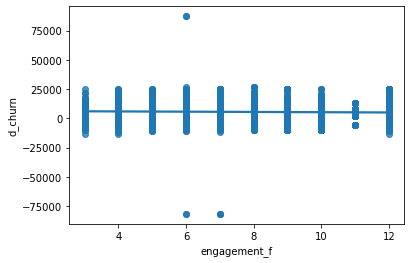

In [363]:
sns.regplot(x="engagement_f", y="d_churn", data=df_churn_merge)

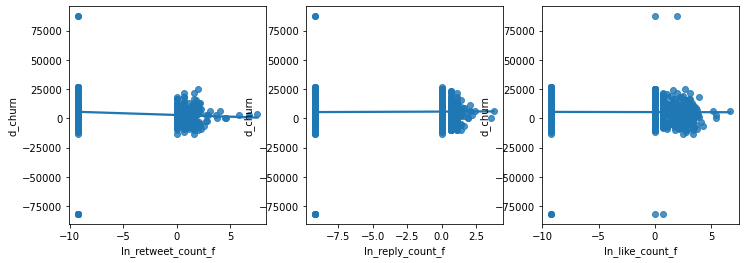

In [298]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.regplot(x="ln_retweet_count_f", y="d_churn", data=df_churn_merge, ax=ax1)
ax1.set_xlabel("ln_retweet_count_f")
ax1.set_ylabel("d_churn")
# ax1.set_title("Not in Reply to User")
# ax1.set_xticks(np.arange(-3,15,1))

sns.regplot(x="ln_reply_count_f", y="d_churn", data=df_churn_merge, ax=ax2)
ax2.set_xlabel("ln_reply_count_f")
ax2.set_ylabel("d_churn")
# ax2.set_title("In Reply to User")
# ax2.set_xticks(np.arange(-3,15,1))

sns.regplot(x="ln_like_count_f", y="d_churn", data=df_churn_merge, ax=ax3)
ax3.set_xlabel("ln_like_count_f")
ax3.set_ylabel("d_churn")
# ax2.set_title("In Reply to User")
# ax2.set_xticks(np.arange(-3,15,1))

plt.show()

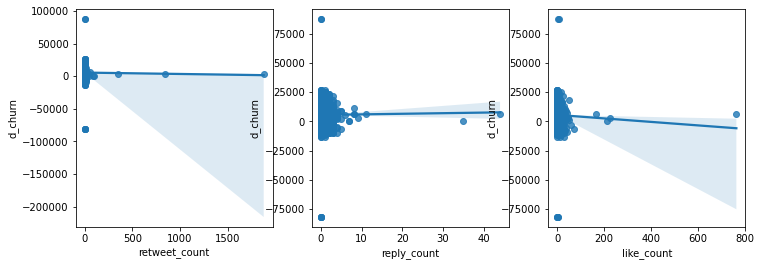

In [299]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.regplot(x="retweet_count", y="d_churn", data=df_churn_merge, ax=ax1)
ax1.set_xlabel("retweet_count")
ax1.set_ylabel("d_churn")
# ax1.set_title("Not in Reply to User")
# ax1.set_xticks(np.arange(-3,15,1))

sns.regplot(x="reply_count", y="d_churn", data=df_churn_merge, ax=ax2)
ax2.set_xlabel("reply_count")
ax2.set_ylabel("d_churn")
# ax2.set_title("In Reply to User")
# ax2.set_xticks(np.arange(-3,15,1))

sns.regplot(x="like_count", y="d_churn", data=df_churn_merge, ax=ax3)
ax3.set_xlabel("like_count")
ax3.set_ylabel("d_churn")
# ax2.set_title("In Reply to User")
# ax2.set_xticks(np.arange(-3,15,1))

plt.show()

### Temporal Association


<AxesSubplot:xlabel='engagement_f', ylabel='d_churn'>

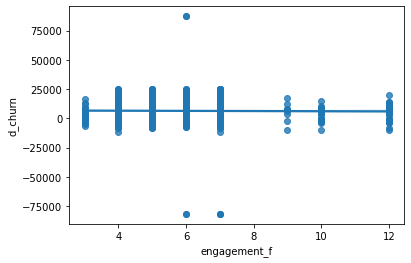

In [300]:
sns.regplot(
    x="engagement_f",
    y="d_churn",
    data=df_churn_merge[df_churn_merge.season_f == "winter"],
)

<AxesSubplot:xlabel='engagement_f', ylabel='d_churn'>

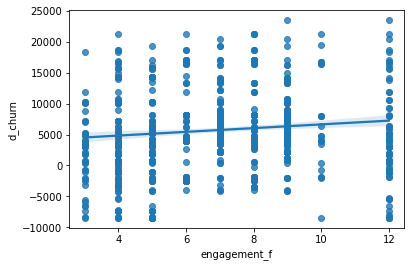

In [301]:
sns.regplot(
    x="engagement_f",
    y="d_churn",
    data=df_churn_merge[df_churn_merge.season_f == "summer"],
)

<AxesSubplot:xlabel='engagement_f', ylabel='d_churn'>

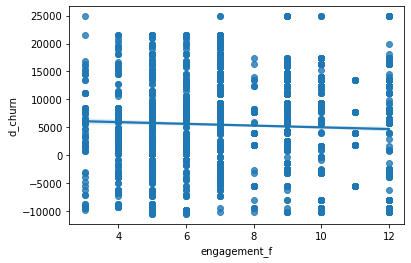

In [302]:
sns.regplot(
    x="engagement_f",
    y="d_churn",
    data=df_churn_merge[df_churn_merge.season_f == "autum"],
)

<AxesSubplot:xlabel='engagement_f', ylabel='d_churn'>

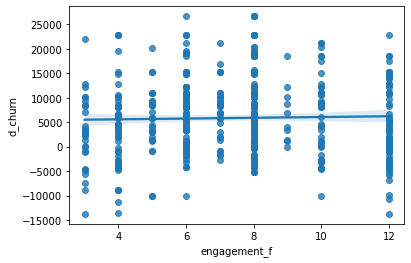

In [303]:
sns.regplot(
    x="engagement_f",
    y="d_churn",
    data=df_churn_merge[df_churn_merge.season_f == "spring"],
)

In [304]:
df_churn_merge.d_churn

0       16286.0
1       16286.0
2       16286.0
3       16286.0
4       16286.0
         ...   
6717    -1389.0
6718     -996.0
6719     2833.0
6720     2833.0
6721    -1680.0
Name: d_churn, Length: 6722, dtype: float64

In [305]:
# essentially group by day and average the engagement scores
df_churn_merge_regression = (
    df_churn_merge.groupby(
        by=["season_f", "covid_lockdown_f", "date_str", "in_reply_to_user_id_f"]
    )
    .agg(
        {
            "engagement_f": "mean",
            "retweet_count": "mean",
            "reply_count": "mean",
            "like_count": "mean",
            "sentiment_score_f": "mean",
            "round_sentiment": "mean",
            "d_churn": "mean",
        }
    )
    .reset_index()
)

In [306]:
df_churn_merge_regression = pd.get_dummies(
    df_churn_merge_regression,
    columns=["in_reply_to_user_id_f", "covid_lockdown_f", "season_f"],
)

In [307]:
mdl = """engagement_f ~ 1 + d_churn """

fit = ols(mdl, data=df_churn_merge_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.698
Date:                Sun, 18 Dec 2022   Prob (F-statistic):             0.0549
Time:                        21:13:21   Log-Likelihood:                -1708.7
No. Observations:                 707   AIC:                             3421.
Df Residuals:                     705   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4646      0.115     56.382      0.0

In [308]:
mdl = """engagement_f ~ 1 + d_churn + in_reply_to_user_id_f_yes  + season_f_winter + season_f_summer + season_f_spring + sentiment_score_f"""


fit = ols(mdl, data=df_churn_merge_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           engagement_f   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 18 Dec 2022   Prob (F-statistic):          1.88e-140
Time:                        21:13:21   Log-Likelihood:                -1375.5
No. Observations:                 707   AIC:                             2765.
Df Residuals:                     700   BIC:                             2797.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## what varaibles do explain churn?

In [309]:
mdl = """d_churn ~ 1 + retweet_count + reply_count + like_count + in_reply_to_user_id_f_yes  + season_f_winter + season_f_summer + season_f_spring + sentiment_score_f"""


fit = ols(mdl, data=df_churn_merge_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                d_churn   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.962
Date:                Sun, 18 Dec 2022   Prob (F-statistic):            0.00289
Time:                        21:13:21   Log-Likelihood:                -7418.3
No. Observations:                 707   AIC:                         1.485e+04
Df Residuals:                     698   BIC:                         1.490e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

in_reply_to_user_id_f_0 -3159.2510   1244.362     -2.539      0.012   -5607.778    -710.724


---> THIS IS IMPORTANT: SO IF IT IS NOT IN REPLY TO USER then this is assiciated with more churn than the other way around

### Create a simple historgam where you group by month etc the customer churn and essentially show a line plot of the user engagement on top of it

In [310]:
df_churn_merge_regression["week"] = pd.to_datetime(
    df_churn_merge_regression.date_str
).dt.week

df_churn_merge_regression["year"] = pd.to_datetime(
    df_churn_merge_regression.date_str
).dt.year

df_churn_merge_regression["month"] = pd.to_datetime(
    df_churn_merge_regression.date_str
).dt.month

In [311]:
df_churn_merge_regression["ln_retweet_count"] = np.log(
    df_churn_merge_regression["retweet_count"]
)
df_churn_merge_regression["ln_reply_count"] = np.log(
    df_churn_merge_regression["reply_count"]
)
df_churn_merge_regression["ln_like_count"] = np.log(
    df_churn_merge_regression["like_count"]
)

In [312]:
np.log(df_tweets.like_count).describe()

count    18567.000000
mean        -5.993145
std          4.885443
min         -9.210340
25%         -9.210340
50%         -9.210340
75%          0.000100
max          8.745125
Name: like_count, dtype: float64

In [313]:
df_customer_Churn["year"] = pd.to_datetime(df_customer_Churn.date_str).dt.year

df_customer_Churn["month"] = pd.to_datetime(df_customer_Churn.date_str).dt.month


df_customer_Churn["year_month"] = (
    df_customer_Churn["year"].astype(str) + "_" + df_customer_Churn["month"].astype(str)
)
grouped_churn = (
    df_customer_Churn.groupby(by="year_month").agg({"d_churn": "mean"}).reset_index()
)

In [314]:
df_churn_plot = (
    df_merged.reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "count_tweets"})
    .groupby(by=["year", "month"])
    .agg(
        {
            # "d_churn": "mean",
            "sentiment_score_f": "mean",
            "count_tweets": "count",
            "retweet_count": "mean",
            "reply_count": "mean",
            "like_count": "mean",
            "ln_retweet_count_f": "mean",
            "ln_reply_count_f": "mean",
            "ln_like_count_f": "mean",
        }
    )
    .reset_index()
)

In [315]:
# the case here:
# 1. should you take the average eg retweet_count per month and then take the log of that or
# 2. first take the log and then average the average log value  (this is what I did )

In [316]:
# potential alterantive
df_churn_plot["ln_retweet_count_f"] = np.log(df_churn_plot["retweet_count"])
df_churn_plot["ln_reply_count_f"] = np.log(df_churn_plot["reply_count"])
df_churn_plot["ln_like_count_f"] = np.log(df_churn_plot["like_count"])

In [317]:
# ln_reetc = df_churn_plot.loc[:, ["year_month", "ln_retweet_count"]].rename(
#     columns={"ln_retweet_count": "value"}
# )
# ln_reetc["var"] = "ln_retweet_count"
# ln_replyc = df_churn_plot.loc[:, ["year_month", "ln_reply_count"]].rename(
#     columns={"ln_reply_count": "value"}
# )
# ln_replyc["var"] = "ln_reply_count"
# ln_likec = df_churn_plot.loc[:, ["year_month", "ln_like_count"]].rename(
#     columns={"ln_like_count": "value"}
# )
# ln_likec["var"] = "ln_like_count"

# tot = ln_reetc.append(ln_replyc, ignore_index=True)
# tot = tot.append(ln_likec)

In [318]:
df_churn_plot = df_churn_plot[df_churn_plot.year >= 2021]

In [319]:
df_churn_plot["year_month"] = (
    df_churn_plot["year"].astype(str) + "_" + df_churn_plot["month"].astype(str)
)

In [320]:
grouped__ = pd.merge(
    left=df_churn_plot,
    right=grouped_churn,
    left_on="year_month",
    right_on="year_month",
    how="inner",
)

In [321]:
grouped__.describe()

,year,month,sentiment_score_f,count_tweets,retweet_count,reply_count,like_count,ln_retweet_count_f,ln_reply_count_f,ln_like_count_f,d_churn
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2021.454545,6.045455,0.711429,319.681818,1.354125,0.460912,2.718434,-1.127525,-0.813060,0.258232,4602.110148
std,0.509647,3.316298,0.627729,437.207740,2.435269,0.137003,3.368070,1.786957,0.278867,1.271342,2705.913648
min,2021.000000,1.000000,0.153402,23.000000,0.027299,0.280563,0.189336,-3.600902,-1.270957,-1.664231,-346.064516
25%,2021.000000,3.250000,0.189879,50.500000,0.067983,0.378827,0.501856,-2.690691,-0.970677,-0.694502,2493.927419
50%,2021.000000,6.000000,0.295574,205.500000,0.325831,0.424728,0.990455,-1.122091,-0.856592,-0.009613,4648.730991
75%,2022.000000,8.750000,1.232024,324.500000,1.126123,0.536272,3.859012,0.117833,-0.623235,1.319726,7070.709052
max,2022.000000,12.000000,1.909941,1728.000000,8.938489,0.793203,9.950920,2.190367,-0.231676,2.297665,7975.413793


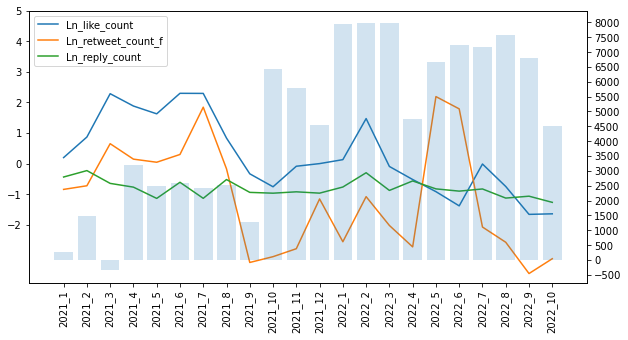

In [322]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot a simple line chart
ax.plot(grouped__.year_month, grouped__.ln_like_count_f, label="Ln_like_count")

# Plot another line on the same chart/graph
ax.plot(
    grouped__.year_month,
    grouped__.ln_retweet_count_f,
    label="Ln_retweet_count_f",
)

ax.plot(grouped__.year_month, grouped__.ln_reply_count_f, label="Ln_reply_count")
ax.legend(loc=2)


ax.set_xticklabels(
    labels=grouped__.year_month,
    rotation=90,
)
ax.set_yticks(np.arange(-2, 6, 1))


ax2 = ax.twinx()
ax2.bar(grouped__.year_month, grouped__.d_churn, alpha=0.2, label="Ln_reply_count")
ax2.set_yticks(range(-500, 8001, 500))


plt.show()

In [323]:
grouped__corr = grouped__.loc[
    :,
    [
        "sentiment_score_f",
        "count_tweets",
        "retweet_count",
        "reply_count",
        "like_count",
        "ln_retweet_count_f",
        "ln_reply_count_f",
        "ln_like_count_f",
        "d_churn",
    ],
]

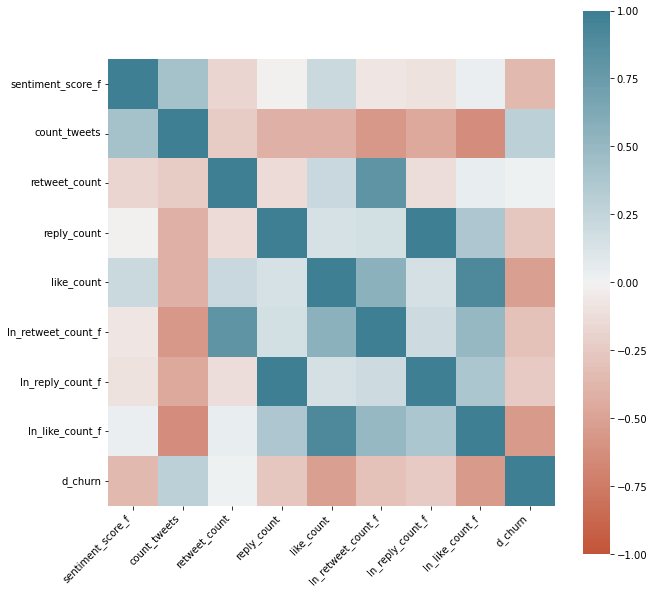

In [324]:
fig, ax = plt.subplots(figsize=(10, 10))
corr = grouped__corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

None

Text(0.5, 1.0, 'Correlation Heatmap')

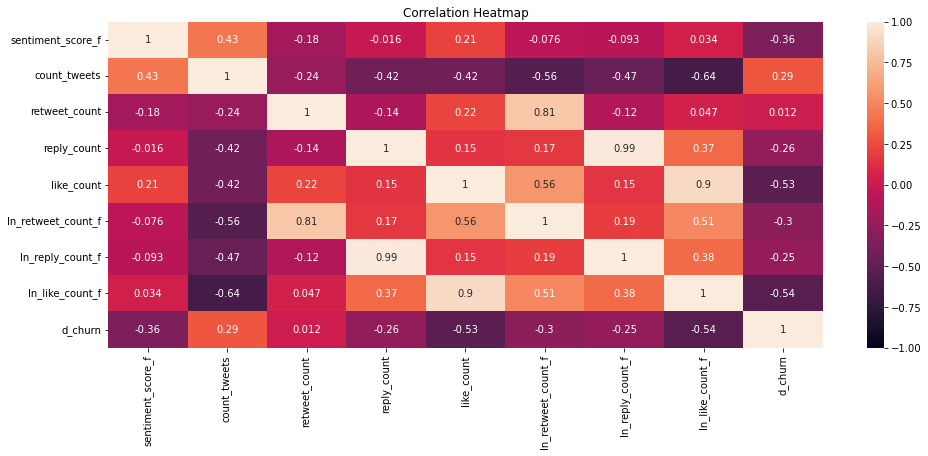

In [325]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(grouped__corr.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=5)

In [326]:
corr = grouped__corr.corr()
corr.style.background_gradient(cmap="coolwarm")

,sentiment_score_f,count_tweets,retweet_count,reply_count,like_count,ln_retweet_count_f,ln_reply_count_f,ln_like_count_f,d_churn
sentiment_score_f,1.000000,0.428653,-0.181900,-0.016124,0.213872,-0.076243,-0.092645,0.033748,-0.362348
count_tweets,0.428653,1.000000,-0.240656,-0.417281,-0.418486,-0.559054,-0.468384,-0.637858,0.294656
retweet_count,-0.181900,-0.240656,1.000000,-0.140672,0.219040,0.809679,-0.121128,0.046843,0.011764
reply_count,-0.016124,-0.417281,-0.140672,1.000000,0.147520,0.171371,0.988785,0.370090,-0.263573
like_count,0.213872,-0.418486,0.219040,0.147520,1.000000,0.563977,0.153451,0.903220,-0.526994
ln_retweet_count_f,-0.076243,-0.559054,0.809679,0.171371,0.563977,1.000000,0.190250,0.506398,-0.303099
ln_reply_count_f,-0.092645,-0.468384,-0.121128,0.988785,0.153451,0.190250,1.000000,0.377464,-0.250820
ln_like_count_f,0.033748,-0.637858,0.046843,0.370090,0.903220,0.506398,0.377464,1.000000,-0.540744
d_churn,-0.362348,0.294656,0.011764,-0.263573,-0.526994,-0.303099,-0.250820,-0.540744,1.000000


# Part 4

1. df_merged[df_merged.in_reply_to_user_id.isna()].round_sentiment.mean() vs df_merged[~df_merged.in_reply_to_user_id.isna()].round_sentiment.mean()

2. those with hashtags vs those without hashtags 

3. Before and after corona??? is there a difference in sentiment?






Based on the previous analysis of the tweet texts (hashtags, bigrams, other expressions, or even clusters) choose one (product or service) innovation that JustEatTakeAway.com has announced on Twitter. You may use one of the directions suggested below or your own idea from the previous analyses. *Please, note that we do not ask you to manually label a large sample of tweets to assess their content. It would be enough if you take a dictionary-based approach. This means that the tweets can be labelled algorithmically based on certain rules that you will set. For example, you can create an indicator (dummy) variable which takes 1 if the tweet contains certain words related to sustainability improvement, and 0 otherwise.
POSSIBLE DIRECTIONS FOR INNOVATION ANALYSIS IN QUESTION 4:

Special delivery services: delivery to airports and other public places, delivery of groceries
Improvement of sustainability: more organic food / restaurants, less plastic and food waste
Courier hiring
Charity
Events organization
Collaborations with other companies


4.1 Describe how this innovation (introduction or improvement of the products or processes) would affect the platform performance via the same-side and / or cross-side network effects. (1 slide)

4.2 Out of all tweets of the sample, please, choose tweets which mention this innovation area, based on the dictionary approach. Perform a similar analysis as in point 3.1. What does the platform tweet about in tweets related to the chosen innovation? (1 slide)

4.3 Does the company post about this innovation with positive or negative sentiment? How do users react to this innovation: is user engagement higher or lower for posts/ replies about this innovation compared to other posts? For this analysis you may choose between descriptive and / or regression analysis depending on the number of tweets mentioning the innovation of your choice in your sample. (2 slides)

4.4 Do the competitors of JustEatTakeAway.com announce in their tweets a similar innovation, earlier or later than JustEatTakeAway.com? Is there platform envelopment taking place, to your opinion, and why? (1 slide)



### 4.1 Describe how this innovation (introduction or improvement of the products or processes) would affect the platform performance via the same-side and / or cross-side network effects. (1 slide)



in the most important and frequent hashtags contained foodcycle and surplusfood and pollution; These also loaded usually on the sustainability topic 

sustanability_and_charity_efforts_idx

corporate social responsiblity!!! innovation!

corporate_social_responsiblity_sustaniblity_and_charity_idx

In [327]:
len(
    set(
        list(df_merged[df_merged.text.str.contains("sustainable")].index)
        + list(df_merged[df_merged.text.str.contains("waste")].index)
        + list(df_merged[df_merged.text.str.contains("pollution")].index)
        + list(df_merged[df_merged.text.str.contains("sustainability")].index)
        + list(df_merged[df_merged.text.str.contains("plastic")].index)
        + list(df_merged[df_merged.text.str.contains("organic")].index)
        + list(df_merged[df_merged.text.str.contains("surplus")].index)
        + list(df_merged[df_merged.text.str.contains("surplusfood")].index)
        + list(df_merged[df_merged.text.str.contains("foodcycle")].index)
    )
)

266

### 4.2 Out of all tweets of the sample, please, choose tweets which mention this innovation area, based on the dictionary approach. Perform a similar analysis as in point 3.1. What does the platform tweet about in tweets related to the chosen innovation? (1 slide)

In [328]:
df_merged["text_lower"] = df_merged.text.str.lower()

corporate_social_responsiblity_sustaniblity_and_charity_idx = list(
    set(
        list(df_merged[df_merged.text_lower.str.contains("sustainable")].index)
        + list(df_merged[df_merged.text_lower.str.contains("waste")].index)
        + list(df_merged[df_merged.text_lower.str.contains("pollution")].index)
        + list(df_merged[df_merged.text_lower.str.contains("sustainability")].index)
        + list(df_merged[df_merged.text_lower.str.contains("plastic")].index)
        + list(df_merged[df_merged.text_lower.str.contains("organic")].index)
        + list(df_merged[df_merged.text_lower.str.contains("surplus")].index)
        + list(df_merged[df_merged.text_lower.str.contains("surplusfood")].index)
        + list(df_merged[df_merged.text_lower.str.contains("foodcycle")].index)
        + list(df_merged[df_merged.text_lower.str.contains("environment")].index)
        + list(df_merged[df_merged.text_lower.str.contains("renewable")].index)
        + list(df_merged[df_merged.text_lower.str.contains("eco-friendly")].index)
        + list(df_merged[df_merged.text_lower.str.contains("ecologic")].index)
        + list(df_merged[df_merged.text_lower.str.contains("green energy")].index)
    )
)

In [329]:
len(corporate_social_responsiblity_sustaniblity_and_charity_idx)

295

In [330]:
df_merged["corporate_social_responsiblity_f"] = "no"

df_merged.loc[
    df_merged.reset_index().index.isin(
        corporate_social_responsiblity_sustaniblity_and_charity_idx
    ),
    "corporate_social_responsiblity_f",
] = "yes"

In [331]:
df_regression = df_merged.loc[
    :,
    [
        "relevant_hashtag_f",
        "engagement_f",
        "day_bin_f",
        "in_reply_to_user_id_f",
        "season_f",
        "topic_loadings_strong_f",
        "relevant_topic_loading_f",
        "covid_lockdown_f",
        "weekday_f",
        "retweet_count",
        "reply_count",
        "like_count",
        "ln_retweet_count_f",
        "ln_reply_count_f",
        "ln_like_count_f",
        "sentiment_score_f",
        "sentiment_class_f",
        "corporate_social_responsiblity_f",
    ],
]


df_regression = pd.get_dummies(
    df_regression,
    columns=[
        "relevant_hashtag_f",
        "day_bin_f",
        "in_reply_to_user_id_f",
        "season_f",
        "topic_loadings_strong_f",
        "relevant_topic_loading_f",
        "covid_lockdown_f",
        "weekday_f",
        "sentiment_class_f",
        "corporate_social_responsiblity_f",
    ],
)

In [332]:
mdl = """
retweet_count ~ 1 + sentiment_score_f + corporate_social_responsiblity_f_yes + covid_lockdown_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes+ 
weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ relevant_topic_loading_f_1

"""

fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:          retweet_count   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8.311
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           4.41e-18
Time:                        21:13:24   Log-Likelihood:                -42898.
No. Observations:                8874   AIC:                         8.583e+04
Df Residuals:                    8859   BIC:                         8.593e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [333]:
mdl = """
like_count ~ 1 + sentiment_score_f + corporate_social_responsiblity_f_yes + covid_lockdown_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes+ 
weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ relevant_topic_loading_f_1

"""

fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     98.35
Date:                Sun, 18 Dec 2022   Prob (F-statistic):          7.59e-265
Time:                        21:13:24   Log-Likelihood:                -33292.
No. Observations:                8874   AIC:                         6.661e+04
Df Residuals:                    8859   BIC:                         6.672e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [334]:
mdl = """
reply_count ~ 1 + sentiment_score_f + corporate_social_responsiblity_f_yes + covid_lockdown_f_1 + season_f_winter + season_f_summer + season_f_spring + in_reply_to_user_id_f_yes+ 
weekday_f_Monday + weekday_f_Saturday + weekday_f_Sunday + weekday_f_Thursday + weekday_f_Tuesday + weekday_f_Wednesday 
+ relevant_topic_loading_f_1

"""

fit = ols(mdl, data=df_regression).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            reply_count   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.840
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           3.73e-14
Time:                        21:13:24   Log-Likelihood:                -12171.
No. Observations:                8874   AIC:                         2.437e+04
Df Residuals:                    8859   BIC:                         2.448e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## What does the platform tweet about in tweets related to the chosen innovation?
### WORDCLOUD!!

In [335]:
df_merged[df_merged.corporate_social_responsiblity_f == "yes"].processed_words_lemma

354     [always, appreciate, definitely, feedback, mak...
355     [dave, looking, new, partner, reaching, restau...
486                                                [look]
492                                                [look]
493                                                [look]
                              ...                        
8535    [amazing, amazing charity, big, charity, read,...
8561    [ever, find, sustainable, sustainable takeaway...
8563    [aid, amazing, bristol, cycled, huge, huge tha...
8564    [charity, community, done, making, meal, meal ...
8588    [foodwaste, last, last year, partnered, read, ...
Name: processed_words_lemma, Length: 295, dtype: object

In [336]:
CSR_wordcount = {}

# get all words here in the data
for i in df_merged[
    df_merged.corporate_social_responsiblity_f == "yes"
].processed_words_lemma:
    for e in i:
        if e in CSR_wordcount.keys():
            CSR_wordcount[e] += 1
        elif e not in CSR_wordcount.keys():
            CSR_wordcount[e] = 1

CSR_wordcount = (
    pd.DataFrame.from_dict(CSR_wordcount, orient="index", columns=["occurences"])
    .reset_index()
    .rename(columns={"index": "word"})
)
# repeat the same here for the hashtags in the subset of the data

hashtags_df = (
    df_merged[df_merged.corporate_social_responsiblity_f == "yes"]["text"]
    .apply(lambda x: pd.value_counts(re.findall("(#\w+)", x.lower())))
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .sort_values(by=0, ascending=False)
)
hashtags_df.columns = ["word", "occurences"]

In [337]:
CSR_wordcount = CSR_wordcount.append(hashtags_df)
CSR_wordcount["occurences"] = CSR_wordcount.groupby(["word"])["occurences"].transform(
    "sum"
)
CSR_wordcount.set_index("word", inplace=True)

In [338]:
CSR_wordcount.sort_values(by="occurences", ascending=False).head(56)

,occurences
word,
across,112.0
partner,111.0
meal,109.0
charity,99.0
people,90.0
charity partner,79.0
read,78.0
amazing,73.0
food,72.0


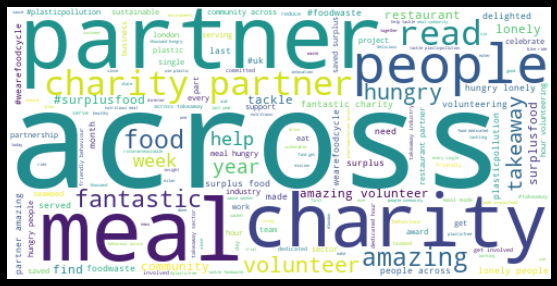

In [339]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color="white",
    max_words=150,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(dict(CSR_wordcount.occurences))

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(10, 5), facecolor="k")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

#### now show that this is primarily driven by tweets by the company and not in reply but alos show the sentiment value vs that of not
##### reply_count, like_count, retweet_count
##### sentiment overall 

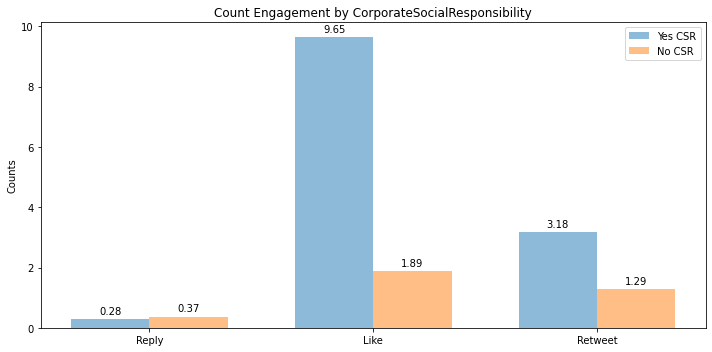

In [340]:
### comparison of reply_count, like_count, retweet_count

reply_yes_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "yes"
].reply_count.mean()

like_yes_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "yes"
].like_count.mean()

retweet_yes_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "yes"
].retweet_count.mean()


reply_no_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "no"
].reply_count.mean()

like_no_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "no"
].like_count.mean()

retweet_no_mean = df_merged[
    df_merged.corporate_social_responsiblity_f == "no"
].retweet_count.mean()

labels = ["Reply", "Like", "Retweet"]
yes_reply_like_retweet = [reply_yes_mean, like_yes_mean, retweet_yes_mean]
no_reply_like_retweet = [reply_no_mean, like_no_mean, retweet_no_mean]


yes_reply_like_retweet = [round(num, 2) for num in yes_reply_like_retweet]
no_reply_like_retweet = [round(num, 2) for num in no_reply_like_retweet]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(
    x - width / 2, yes_reply_like_retweet, width, label="Yes CSR", alpha=0.5
)
rects2 = ax.bar(x + width / 2, no_reply_like_retweet, width, label="No CSR", alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Count Engagement by CorporateSocialResponsibility")
ax.set_xticks(x)

ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

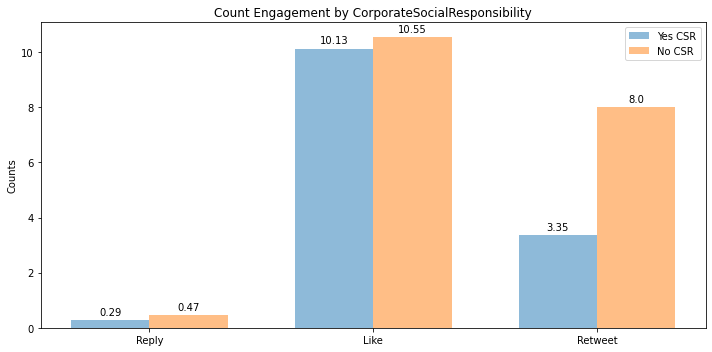

In [341]:
### comparison of reply_count, like_count, retweet_count

reply_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "no")
].reply_count.mean()

like_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "no")
].like_count.mean()

retweet_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "no")
].retweet_count.mean()


reply_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "no")
].reply_count.mean()

like_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "no")
].like_count.mean()

retweet_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "no")
].retweet_count.mean()


labels = ["Reply", "Like", "Retweet"]
yes_reply_like_retweet = [reply_yes_mean, like_yes_mean, retweet_yes_mean]
no_reply_like_retweet = [reply_no_mean, like_no_mean, retweet_no_mean]


yes_reply_like_retweet = [round(num, 2) for num in yes_reply_like_retweet]
no_reply_like_retweet = [round(num, 2) for num in no_reply_like_retweet]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(
    x - width / 2, yes_reply_like_retweet, width, label="Yes CSR", alpha=0.5
)
rects2 = ax.bar(x + width / 2, no_reply_like_retweet, width, label="No CSR", alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Count Engagement by CorporateSocialResponsibility")
ax.set_xticks(x)

ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

We can clearly see that CSR is very much liked when compared to the other tweets 

##### Important with the aforementioned plots: Those ARE in reply to the users 

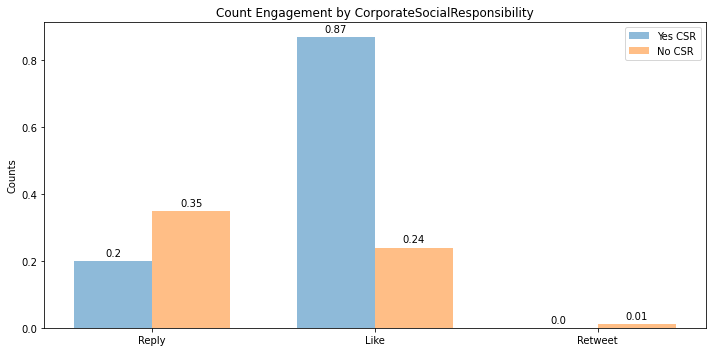

In [342]:
### comparison of reply_count, like_count, retweet_count

reply_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].reply_count.mean()

like_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].like_count.mean()

retweet_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].retweet_count.mean()


reply_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].reply_count.mean()

like_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].like_count.mean()

retweet_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].retweet_count.mean()


labels = ["Reply", "Like", "Retweet"]
yes_reply_like_retweet = [reply_yes_mean, like_yes_mean, retweet_yes_mean]
no_reply_like_retweet = [reply_no_mean, like_no_mean, retweet_no_mean]


yes_reply_like_retweet = [round(num, 2) for num in yes_reply_like_retweet]
no_reply_like_retweet = [round(num, 2) for num in no_reply_like_retweet]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(
    x - width / 2, yes_reply_like_retweet, width, label="Yes CSR", alpha=0.5
)
rects2 = ax.bar(x + width / 2, no_reply_like_retweet, width, label="No CSR", alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Count Engagement by CorporateSocialResponsibility")
ax.set_xticks(x)

ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

so based on the tweets, overall customers liked this effort a lot!

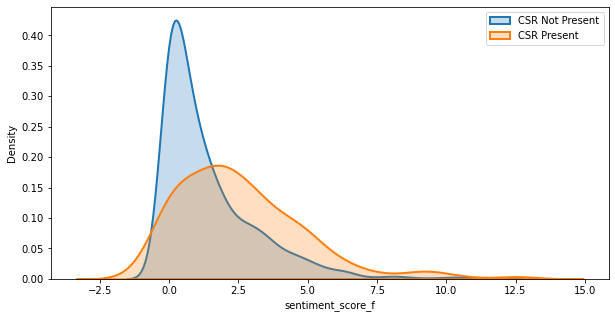

In [343]:
## line plot with sentiment

fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "no")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Not Present",
)

sns.distplot(
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "yes")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Present",
)

ax.legend()

# ax.set_yticks(np.arange(-9, 3, 1))


plt.show()

apparently the compnay does not try to exploit this as much as inform about this 
For CSR present there is more negative and more positive df_tweets

eg tryign to raise awarenes over a problem will cause a negative sentiment score 

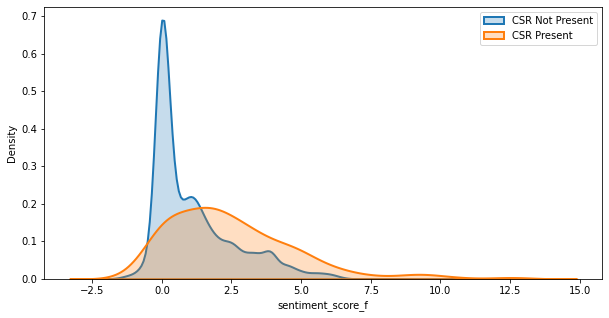

In [344]:
## line plot with sentiment

fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(
    df_merged[(df_merged.corporate_social_responsiblity_f == "no")].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Not Present",
)

sns.distplot(
    df_merged[(df_merged.corporate_social_responsiblity_f == "yes")].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Present",
)

ax.legend()

# ax.set_yticks(np.arange(-9, 3, 1))


plt.show()

In [345]:
# IMPORTANT: take into account that the companies tweets should be take in reply to user == 0

# df_merged[(df_merged.in_reply_to_user_id_f == "no")]

### 4.3 Does the company post about this innovation with positive or negative sentiment? How do users react to this innovation: is user engagement higher or lower for posts/ replies about this innovation compared to other posts? For this analysis you may choose between descriptive and / or regression analysis depending on the number of tweets mentioning the innovation of your choice in your sample. (2 slides)

##### Point 4.3: the sentiment and the user engagement in selected tweets is compared with any other subsample of tweets, via a t-test, a histogram with confidence intervals or any other suitable method.

### I) Does the company post about this innovation with positive or negative sentiment?

1. df_merged[df_merged.in_reply_to_user_id.isna()].round_sentiment.mean() vs df_merged[~df_merged.in_reply_to_user_id.isna()].round_sentiment.mean()

2. those with hashtags vs those without hashtags 

3. Before and after corona??? is there a difference in sentiment?


Paired Sample T-Test

In [346]:
stats.ttest_ind(
    df_merged[
        (df_merged.in_reply_to_user_id_f == "yes")
        & (df_merged.corporate_social_responsiblity_f == "yes")
    ].sentiment_score,
    df_merged[
        (df_merged.in_reply_to_user_id_f == "no")
        & (df_merged.corporate_social_responsiblity_f == "yes")
    ].sentiment_score,
)

Ttest_indResult(statistic=-3.2060421453112045, pvalue=0.0014945308215155554)

In [347]:
stats.ttest_ind(
    df_merged[
        (df_merged.in_reply_to_user_id_f == "yes")
        & (df_merged.corporate_social_responsiblity_f == "yes")
    ].sentiment_score,
    df_merged[
        (df_merged.in_reply_to_user_id_f == "yes")
        & (df_merged.corporate_social_responsiblity_f == "no")
    ].sentiment_score,
)

Ttest_indResult(statistic=-1.0739663443421432, pvalue=0.28287366697186844)

In [348]:
stats.ttest_ind(
    df_merged[
        (df_merged.in_reply_to_user_id_f == "no")
        & (df_merged.corporate_social_responsiblity_f == "yes")
    ].sentiment_score,
    df_merged[
        (df_merged.in_reply_to_user_id_f == "no")
        & (df_merged.corporate_social_responsiblity_f == "no")
    ].sentiment_score,
)

Ttest_indResult(statistic=9.841713136764165, pvalue=3.0031439479989837e-22)

###  the main thing here: for this question I)

In [349]:
# the main thing here:
stats.ttest_ind(
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "no")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score,
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "yes")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score,
)

Ttest_indResult(statistic=-9.841713136764165, pvalue=3.0031439479989837e-22)

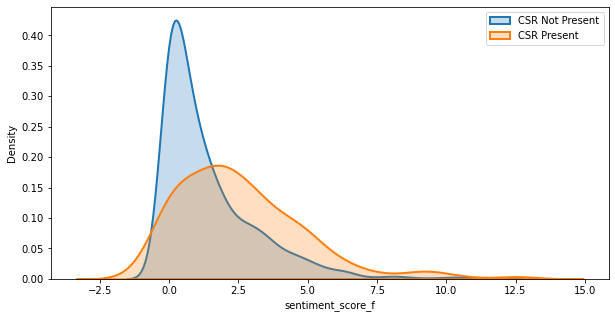

In [350]:
## line plot with sentiment

fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "no")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Not Present",
)

sns.distplot(
    df_merged[
        (df_merged.corporate_social_responsiblity_f == "yes")
        & (df_merged.in_reply_to_user_id_f == "no")
    ].sentiment_score_f,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 2},
    label="CSR Present",
)

ax.legend()

# ax.set_yticks(np.arange(-9, 3, 1))


plt.show()

### II) How do users react to this innovation: is user engagement higher or lower for posts/ replies about this innovation compared to other posts?

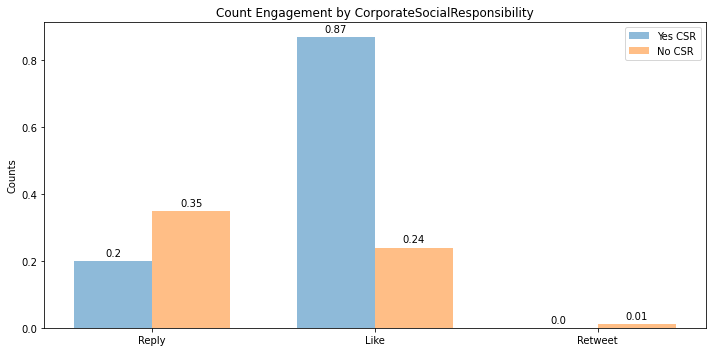

In [351]:
### comparison of reply_count, like_count, retweet_count

reply_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].reply_count.mean()

like_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].like_count.mean()

retweet_yes_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "yes")
    & (df_merged.in_reply_to_user_id_f == "yes")
].retweet_count.mean()


reply_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].reply_count.mean()

like_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].like_count.mean()

retweet_no_mean = df_merged[
    (df_merged.corporate_social_responsiblity_f == "no")
    & (df_merged.in_reply_to_user_id_f == "yes")
].retweet_count.mean()


labels = ["Reply", "Like", "Retweet"]
yes_reply_like_retweet = [reply_yes_mean, like_yes_mean, retweet_yes_mean]
no_reply_like_retweet = [reply_no_mean, like_no_mean, retweet_no_mean]


yes_reply_like_retweet = [round(num, 2) for num in yes_reply_like_retweet]
no_reply_like_retweet = [round(num, 2) for num in no_reply_like_retweet]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(
    x - width / 2, yes_reply_like_retweet, width, label="Yes CSR", alpha=0.5
)
rects2 = ax.bar(x + width / 2, no_reply_like_retweet, width, label="No CSR", alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Count Engagement by CorporateSocialResponsibility")
ax.set_xticks(x)

ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### 4.4 Do the competitors of JustEatTakeAway.com announce in their tweets a similar innovation, earlier or later than JustEatTakeAway.com? Is there platform envelopment taking place, to your opinion, and why? (1 slide)

#### Point 4.4: The earliest appearance of mentions of the chosen innovation is compared between JET and the competitors, the answer about the possible platform envelopment is explained.

In [442]:
df_tweets["text_lower"] = df_tweets.text.str.lower()

corporate_social_responsiblity_sustaniblity_and_charity_idx = list(
    set(
        list(df_tweets[df_tweets.text_lower.str.contains("sustainable")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("waste")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("pollution")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("sustainability")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("plastic")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("organic")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("surplus")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("surplusfood")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("foodcycle")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("environment")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("renewable")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("eco-friendly")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("ecologic")].index)
        + list(df_tweets[df_tweets.text_lower.str.contains("green energy")].index)
    )
)

In [443]:
len(corporate_social_responsiblity_sustaniblity_and_charity_idx)

311

In [444]:
df_tweets["corporate_social_responsiblity_f"] = "no"
df_tweets["corporate_social_responsiblity"] = 0
df_tweets.loc[
    df_tweets.reset_index().index.isin(
        corporate_social_responsiblity_sustaniblity_and_charity_idx
    ),
    "corporate_social_responsiblity_f",
] = "yes"


df_tweets.loc[
    df_tweets.reset_index().index.isin(
        corporate_social_responsiblity_sustaniblity_and_charity_idx
    ),
    "corporate_social_responsiblity",
] = 1

In [445]:
# first create year_month
df_tweets["year"] = pd.to_datetime(df_tweets.created_at).dt.year

df_tweets["month"] = pd.to_datetime(df_tweets.created_at).dt.quarter


df_tweets["year_month"] = (
    df_tweets["year"].astype(str) + "_" + df_tweets["month"].astype(str)
)

In [446]:
# create a vaiable that sums all JET togeter but not its competitors
df_tweets["company_names"] = df_tweets["full_name"]

df_tweets.loc[
    df_tweets.full_name.isin(
        ["thuisbezorgd", "Thuisbezorgd.nl", "Just Eat Takeaway.com", "Just Eat UK"]
    ),
    "company_names",
] = "JET"

In [447]:
df_tweets["Company"] = "Competition"

df_tweets.loc[df_tweets.company_names == "JET", "Company"] = "JET"

In [448]:
# essentially count the number of these tweets by competitor by year_month
df_competitor_comparison = (
    df_tweets.groupby(by=["Company", "year", "month"]).agg(
        {"corporate_social_responsiblity": "sum", "tweet_id": "count"}
    )
).reset_index()

In [449]:
df_competitor_comparison["year_month"] = (
    df_competitor_comparison["year"].astype(str)
    + " Q"
    + df_competitor_comparison["month"].astype(str)
)

In [450]:
df_competitor_comparison["proportion_to_total_tweets"] = (
    df_competitor_comparison["corporate_social_responsiblity"]
    / df_competitor_comparison["tweet_id"]
)

In [451]:
df_competitor_comparison.Company.unique()

array(['Competition', 'JET'], dtype=object)

In [452]:
df_competitor_comparison.sort_values(by=["year", "month"], inplace=True)

df_competitor_comparison = df_competitor_comparison[
    df_competitor_comparison.year > 2015
]

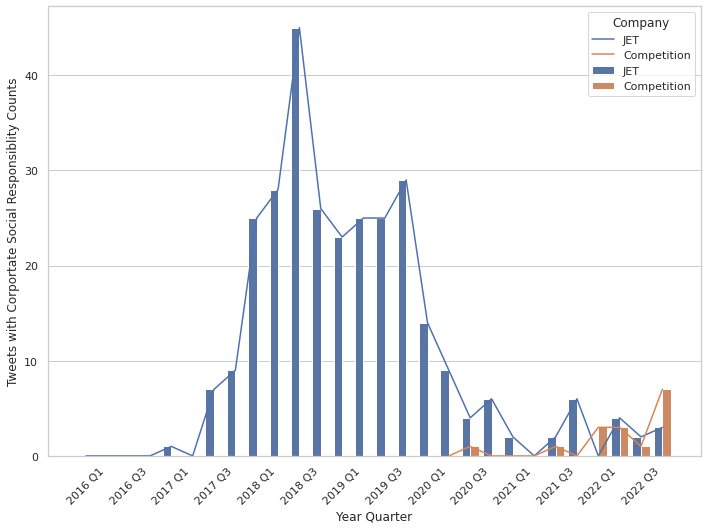

In [498]:
sns.set_style("whitegrid")

sns.barplot(
    data=df_competitor_comparison,
    x="year_month",
    y="corporate_social_responsiblity",
    hue="Company",
    dodge=True,
    ci=95,
)

# sns.lineplot(
#     data=df_competitor_comparison,
#     x="year_month",
#     y="corporate_social_responsiblity",
#     hue="Company",
# )


plt.xticks(
    ticks=range(0, len(list(df_competitor_comparison.year_month.unique())), 2),
    labels=list(df_competitor_comparison.year_month.unique())[::2],
    rotation=45,
)

plt.xlabel("Year Quarter")
plt.ylabel("Tweets with Corportate Social Responsiblity Counts")
None